# Navigation

In this notebook, I'll train an agent to solve the Reacher Environment using Unity ML-Agents.

This project is part of my [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

<img src="https://user-images.githubusercontent.com/10624937/42135619-d90f2f28-7d12-11e8-8823-82b970a54d7e.gif" alt="Navigation Environment" width="500" height="600">

---

# Index

- [1. Setup the Environment](#1.-Setup-the-Environment)
- [2. Start the Environment](#2.-Start-the-Environment)
- [3. Examine the State and Action Spaces](#3.-Examine-the-State-and-Action-Spaces)
- [4. Define helper functions to Agent trainment](#4.-Define-helper-functions-to-Agent-trainment)
- [5. Develop the Agent to collect bananas](#5.-Develop-the-Agent-to-collect-bananas)
 - [5.1 Agent with ReplayMemory](#5.1-Agent-with-ReplayMemory)
 - [5.2 Agent with PrioritizedMemory](#5.2-Agent-with-PrioritizedMemory)
 - [5.3 Plot agents losses along the training sessions](#5.3-Plot-agents-losses-along-the-training-sessions)
 - [5.4 Save weights](#5.4-Save-weights)
 - [5.5 Load weights](#5.5-Load-weights)
- [6. Test Agent on Environment](#6.-Test-Agent-on-Environment)
- [7. Conclusions](#7.-Conclusions)

## 1. Setup the Environment

<img align="left" width="150" src="https://www.nclouds.com/img/services/toolkit/sagemaker.png"/>

This notebook was developed on AWS SageMaker.

The kernel used is **conda_python3**

To setup this environment on SageMaker you need to run the next 3 cells.

In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install -r requirements.txt

In [1]:
!pip -q install ./python

ERROR: Could not find a version that satisfies the requirement torch==0.4.0 (from unityagents==0.4.0) (from versions: 0.1.2, 0.1.2.post1, 0.1.2.post2)
ERROR: No matching distribution found for torch==0.4.0 (from unityagents==0.4.0)


## 2. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import os
import time
import json
import warnings
import numpy as np

from tqdm import tqdm
from agent import Agent
from datetime import datetime
from collections import deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
from sklearn.model_selection import ParameterGrid

warnings.simplefilter("ignore", UserWarning)
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Next, we will start the environment!  **_Before running the code cell below_**, change the `env_path` variable to match the location of the Unity environment that you downloaded.

- **Windows** (x86_64): `"/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86_64, headless): `"/Banana_Linux_NoVis/Banana.x86_64"`

If your system isn't in the list, please, download the environment from [here](https://github.com/udacity/deep-reinforcement-learning/tree/master/p1_navigation).

The `file_name` parameter needs to be something like that:

```
env = UnityEnvironment(file_name="Banana_Linux_NoVis/Banana.x86_64")
```

In [2]:
#env_path = "Banana_Linux_NoVis/Banana.x86_64"
env_path = "Banana_Windows_x86_64/Banana.exe"

env = UnityEnvironment(file_name=env_path)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 3. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


## 4. Define helper functions to Agent trainment

Here we'll create a function that can be very helpful to teach the agent.

In [5]:
def dqn_trainer(agent, n_episodes=100, print_range=10, eps_start=1.0, eps_end=0.01, eps_decay=0.995, early_stop=13, verbose=False):
    """Deep Q-Learning trainer.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        print_range (int): range to print partials results
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        early_stop (int): Stop training when achieve a defined score respecting 10 min n_episodes.
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=print_range)  # last 100 scores
    scores_mean = []
    eps = eps_start                    # initialize epsilon
    for i in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        
        while True:
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0] 
            agent.step(state, action, reward, next_state, done, i)
            state = next_state
            score += reward
            if done:
                break
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        if verbose:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_window)), end="")
            if i % print_range == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_window)))
            
        if np.mean(scores_window) >= early_stop and i > 10:
            if verbose:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i, np.mean(scores_window)))
            break
            
    return scores, i, np.mean(scores_window)

## 5. Develop the Agent to collect bananas

In the next code cells, we will train the Agent to work on environment.

### 5.1 Agent with ReplayMemory

In the next cell we'll teach an agent with `ReplayMemory`.

Episode 10	Average Score: 0.00
Episode 20	Average Score: 0.90
Episode 30	Average Score: 0.200
Episode 40	Average Score: 0.50
Episode 50	Average Score: 0.50
Episode 60	Average Score: 1.90
Episode 70	Average Score: 2.80
Episode 80	Average Score: 1.90
Episode 90	Average Score: 1.20
Episode 100	Average Score: 3.00
Episode 110	Average Score: 1.70
Episode 120	Average Score: 3.90
Episode 130	Average Score: 2.40
Episode 140	Average Score: 5.60
Episode 150	Average Score: 2.90
Episode 160	Average Score: 3.80
Episode 170	Average Score: 5.70
Episode 180	Average Score: 4.00
Episode 190	Average Score: 7.30
Episode 200	Average Score: 7.60
Episode 210	Average Score: 5.70
Episode 220	Average Score: 6.90
Episode 230	Average Score: 6.30
Episode 240	Average Score: 7.30
Episode 250	Average Score: 9.80
Episode 260	Average Score: 9.200
Episode 270	Average Score: 9.20
Episode 280	Average Score: 7.50
Episode 290	Average Score: 10.90
Episode 300	Average Score: 7.700
Episode 310	Average Score: 8.40
Episode 320	A

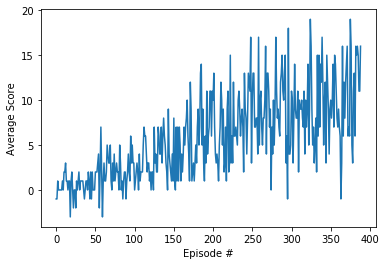

Wall time: 3min 38s


In [7]:
%%time

env_info = env.reset(train_mode=True)[brain_name]

agent = Agent(state_size=state_size, action_size=action_size, seed=199, nb_hidden=(64, 64),
              learning_rate=0.001, memory_size=int(1e6), prioritized_memory=False, batch_size=64,
              gamma=0.9, tau=0.03, small_eps=0.03, update_every=4)

scores, episodes, last_avg_score = dqn_trainer(agent, n_episodes=500, early_stop=13, verbose=True)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Average Score')
plt.xlabel('Episode #')
plt.show()

### 5.2 Agent with PrioritizedMemory

In the next cell we'll teach an agent with `PrioritizedMemory`.

**Important!**: The agent takes a lot of time to learn.

Episode 10	Average Score: -0.10
Episode 20	Average Score: 0.000
Episode 30	Average Score: 0.000
Episode 40	Average Score: -0.10
Episode 50	Average Score: 0.200
Episode 60	Average Score: 1.10
Episode 70	Average Score: 1.50
Episode 80	Average Score: 2.40
Episode 90	Average Score: 3.00
Episode 100	Average Score: 2.40
Episode 110	Average Score: 1.80
Episode 120	Average Score: 4.20
Episode 130	Average Score: 2.80
Episode 140	Average Score: 3.30
Episode 150	Average Score: 4.40
Episode 160	Average Score: 4.10
Episode 170	Average Score: 5.70
Episode 180	Average Score: 4.20
Episode 190	Average Score: 6.20
Episode 200	Average Score: 6.20
Episode 210	Average Score: 8.40
Episode 220	Average Score: 6.90
Episode 230	Average Score: 8.10
Episode 240	Average Score: 6.90
Episode 250	Average Score: 9.30
Episode 260	Average Score: 7.40
Episode 270	Average Score: 8.30
Episode 280	Average Score: 8.90
Episode 290	Average Score: 8.30
Episode 300	Average Score: 10.90
Episode 310	Average Score: 11.90
Episode 32

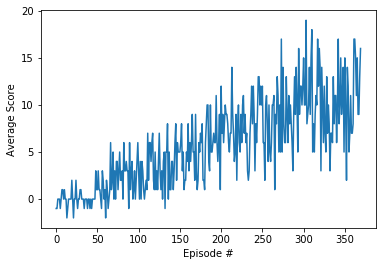

Wall time: 11h 29min 25s


In [8]:
%%time

env_info = env.reset(train_mode=True)[brain_name]

agent = Agent(state_size=state_size, action_size=action_size, seed=199, nb_hidden=(64, 64),
              learning_rate=0.001, memory_size=int(1e6), prioritized_memory=True, batch_size=64,
              gamma=0.9, tau=0.03, small_eps=0.03, update_every=4)

scores, episodes, last_avg_score = dqn_trainer(agent, n_episodes=500, early_stop=13, verbose=True)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Average Score')
plt.xlabel('Episode #')
plt.show()

The agent with prioritized memory took a lot of time on training session, but with slightly less episodes.

### 5.3 Plot agents losses along the training sessions

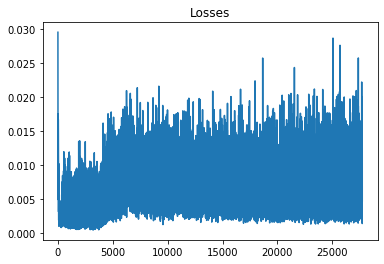

In [9]:
plt.plot(agent.losses)
plt.title("Losses")
plt.show()

### 5.4 Save weights

In [10]:
model_path = "model.pt"
agent.save_model(model_path)

### 5.5 Load weights

In [11]:
model_path = "model.pt"
agent.load_model(model_path)

### 6. Test Agent on Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance.

In [18]:
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
score = 0
eps = 0.05
while True:
    action = agent.act(state, eps)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    score += reward
    state = next_state
    if done:
        break
    
print("Score: {}".format(score))

Score: 24.0


When finished, you can close the environment.

In [ ]:
env.close()

## 7. Conclusions

When we test the trained agent on the environment, we can see that the agent with prioritized memory has more difficult when we don't have yellow bananas near from the agent.

This problem is reduced in trained agent with Replay Memory (with random samples).

To improve the agent we can add a dueling network and try to reproduce epsilon logic on samples choice of Prioritized Memory.